# Things to watch out for while specifying contracts
For the evaluating perception case study, this notebook illustrates the importance of specifying contracts correctly, as this impacts the quality of the contract returned by Pacti. In this script, we consider the running car-pedestrian example where the pedestrian is 5 steps away from the initial condition of the car. The object detection model has two classes: pedestrian and background. 

In [1]:
# ## Example description:
# For this example, we want to find the AG-contract (highlighted in red) of the object detection component, which is specified using bounds of the probability of correctly detecting a pedestrian. This is illustrated as follows:
# ![alt](/imglib/simple_case_study_fig2.png "Case Study overview")

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Import libraries:
from pacti.terms.polyhedra.loaders import readContract

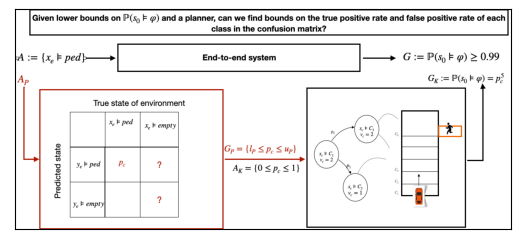

In [3]:
%matplotlib inline
fig, ax = plt.subplots()
img = mpimg.imread("imglib/simple_case_study_fig2.png")
imgplot = ax.imshow(img)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

## First approach to specifying contracts that does not yield the desired quotient contract

This explores a contract specification of this simple example that a user might provide, and illustrates why it might not yield the desried quotient contract. First, we specify the overall system contract as follows (similar to the first approach):
* The assumption assumes a pedestrian: $A_S = \{x_e = 1\}$ 
* The guarantees on overall system level probability: $G_S = \{0.99 \leq \mathbb{P}(s_0 \models \varphi) \leq 1\}$

The specifications of the controller are given as follows:
* The assumption that the probability of correctly detecting a pedestrian is between 0 and 1: $A_K = \{0\leq p \leq 1\}$ 
* The guarantees relate overall probability of satisfaction with the probability of correctly finding the pedestrians: $$G_K = \{\mathbb{P}(s_0 \models \varphi) = 5p - 4, \\ 0.99 \leq \mathbb{P}(s_0 \models \varphi) \leq 1\}.$$
The guarantee $G_K$ is the linear approximation of the non-linear relationship between the overall probability of stopping correctly for the pedestrian with the probability of correctly detecting the pedestrian: $\mathbb{P}(s_0 \models \varphi) = p^5$. Furthermore, we also include the guarantee that the overall system probability lies between 0 and 1.

In [4]:
## System contract: P >= 0.99
def system_contract():
    system_contract = {
        "input_vars": ["x_e"],
        "output_vars": ["P"],
        "assumptions": [{"coefficients": {"x_e": -1}, "constant": -1}, {"coefficients": {"x_e": 1}, "constant": 1}],
        "guarantees": [{"coefficients": {"P": -1}, "constant": -0.99}, {"coefficients": {"P": 1}, "constant": 1}],
    }
    return system_contract


## Perception contract P = p**5 = 5p - 4
def control_contract():
    mc = dict()
    mc = {
        "input_vars": ["p"],
        "output_vars": ["P"],
        "assumptions": [{"coefficients": {"p": 1}, "constant": 1}, {"coefficients": {"p": -1}, "constant": 0}],
        "guarantees": [
            {"coefficients": {"P": 1, "p": -5}, "constant": -4},
            {"coefficients": {"P": -1, "p": 5}, "constant": 4},
            {"coefficients": {"P": -1}, "constant": -0.99},
            {"coefficients": {"P": 1}, "constant": 1},
        ],
    }
    return mc


Cs = readContract(system_contract())
Ck = readContract(control_contract())

print("Overall System Contract:\n" + str(Cs) + "\n")
print("Controller Contract:\n" + str(Ck))

Overall System Contract:
InVars: [<Var x_e>]
OutVars:[<Var P>]
A: -1*x_e <= -1, 1*x_e <= 1
G: -1*P <= -0.99, 1*P <= 1.0

Controller Contract:
InVars: [<Var p>]
OutVars:[<Var P>]
A: 1*p <= 1, -1*p <= 0
G: 1*P + -5*p <= -4.0, -1*P + 5*p <= 4.0, -1*P <= -0.99


### Applying Quotient Operator
Now, we synthesize the contract $(A_P, G_P)$ for the object detection module using the quotient operator: $\mathcal{C}_{S}\backslash \mathcal{C}_{K}$

In [5]:
Cp = Cs.quotient(Ck)
print("Quotient Contract:\n" + str(Cp))

Quotient Contract:
InVars: [<Var x_e>]
OutVars:[<Var p>]
A: -1*x_e <= -1, 1*x_e <= 1
G: 1*p <= 1, -1*p <= 0


### The resulting quotient contract does not satisfy the requirements
The guarantees returned is $G_P = 0 \leq p \leq 1$, which does not yield interesting probabilities. The quotient contract returned by Pacti is correct. The reason why it returns $0\leq p\leq 1$ is because the contract for the controller already guarantees $0.99 \leq P(s_0 \models \varphi) \leq 1$, so the object detection contract does not need to satisfy any additional requirements on $p$.

## Second approach to specifying contracts that yields the desired quotient contract

This illustrates how properly specifying the base contracts can yield the correct quotient contract. First, we specify the overall system contract as follows (similar to the first approach):
* The assumption assumes a pedestrian: $A_S = \{x_e = 1\}$ 
* The guarantees on overall system level probability: $G_S = \{0.99 \leq \mathbb{P}(s_0 \models \varphi) \leq 1\}$

The specifications of the controller are same as above except for the trivial bounds on probability:
* The assumption that the probability of correctly detecting a pedestrian is between 0 and 1: $A_K = \{0\leq p \leq 1\}$ 
* The guarantees relate overall probability of satisfaction with the probability of correctly finding the pedestrians: $G_K = \{\mathbb{P}(s_0 \models \varphi) = 5p - 4\}$.
The guarantee $G_K$ is the linear approximation of the non-linear relationship between the overall probability of stopping correctly for the pedestrian with the probability of correctly detecting the pedestrian: $\mathbb{P}(s_0 \models \varphi) = p^5$

In [6]:
## System contract: P >= 0.99
def system_contract():
    system_contract = {
        "input_vars": ["x_e"],
        "output_vars": ["P"],
        "assumptions": [{"coefficients": {"x_e": -1}, "constant": -1}, {"coefficients": {"x_e": 1}, "constant": 1}],
        "guarantees": [{"coefficients": {"P": -1}, "constant": -0.99}, {"coefficients": {"P": 1}, "constant": 1}],
    }
    return system_contract


## Perception contract P = p**5 = 5p - 4
def control_contract():
    mc = dict()
    mc = {
        "input_vars": ["p"],
        "output_vars": ["P"],
        "assumptions": [{"coefficients": {"p": 1}, "constant": 1}, {"coefficients": {"p": -1}, "constant": 0}],
        "guarantees": [
            {"coefficients": {"P": 1, "p": -5}, "constant": -4},
            {"coefficients": {"P": -1, "p": 5}, "constant": 4},
        ],
    }
    return mc


Cs = readContract(system_contract())
Ck = readContract(control_contract())

print("Overall System Contract:\n" + str(Cs) + "\n")
print("Controller Contract:\n" + str(Ck))

Overall System Contract:
InVars: [<Var x_e>]
OutVars:[<Var P>]
A: -1*x_e <= -1, 1*x_e <= 1
G: -1*P <= -0.99, 1*P <= 1.0

Controller Contract:
InVars: [<Var p>]
OutVars:[<Var P>]
A: 1*p <= 1, -1*p <= 0
G: 1*P + -5*p <= -4, -1*P + 5*p <= 4


### Applying Quotient Operator
Now, we synthesize the contract $(A_P, G_P)$ for the object detection module using the quotient operator: $\mathcal{C}_{S}\backslash \mathcal{C}_{K}$

In [7]:
Cp = Cs.quotient(Ck)
print("Quotient Contract:\n" + str(Cp) + "\n")

Quotient Contract:
InVars: [<Var x_e>]
OutVars:[<Var p>]
A: -1*x_e <= -1, 1*x_e <= 1
G: -5*p <= -4.99000000000000, 1*p <= 1

